## Methodology

- Data Loading & Preprocessing:

• Load the dataset from your drive (or Kaggle input) using PyTorch’s ImageFolder.


• Apply transformations to resize images to 224×224, convert them to 3-channel (even though they are binarized), and normalize using ImageNet statistics.

- Embedding Generation:

• Use a pretrained ResNet18 (with the final classification layer removed) as a feature extractor.


• Compute an embedding (feature vector) for each image in your dataset using a DataLoader.

- Visualization & Quality Check:

• Use PCA or t-SNE on the embeddings to visualize how samples from different classes cluster.


• Inspect clusters for overlaps, outliers, or duplicate images.

- Difficulty Scoring:

• For each class, compute the centroid (mean embedding).


• For every image, compute its distance (e.g., Euclidean) to the class centroid.

• Use this as a “difficulty score” (a higher distance may indicate a more atypical or difficult sample).

- Train/Test Splitting:

• Use stratified splitting (for example, using StratifiedShuffleSplit from scikit‐learn) to ensure each class is proportionately represented.


• Optionally, you can verify that the difficulty distributions in train and test are similar by plotting histograms of the computed difficulty scores.

- Verification:

• Visualize the class-wise and overall embedding distributions (using PCA/t-SNE plots) and difficulty histograms for train and test sets to verify that the split is representative.

## Explanation

- Cells 1–2: Set up your environment, load and inspect your dataset.
- Cell 3: A pretrained ResNet18 is used as a feature extractor to compute embeddings for all images.
- Cell 4: PCA and t-SNE are applied to the embeddings for visualization; you can check if samples from each class cluster nicely.
- Cell 5: For each class, we compute a “difficulty score” (Euclidean distance from the class centroid) for each image. The histogram shows overall variation.
- Cell 6: A stratified train/test split is performed using StratifiedShuffleSplit so that every class is represented proportionally in both splits.
- Cell 7: We recompute embeddings for the train and test subsets and plot the histograms of their difficulty scores. This verifies that the difficulty (and thus likely the “style” or “complexity”) distribution is similar in both sets.


By following this methodology and running the code, you’ll be able to:

- Verify that your OCR dataset is of high quality and well represented in the embedding space.
- Compute a difficulty metric that can be used to check for outliers or imbalances.
- Achieve a train/test split that preserves both class balance and similar difficulty distributions, ensuring a fair evaluation of your model.

Feel free to adjust parameters (such as batch sizes, number of PCA or t-SNE components, etc.) based on your system’s capabilities and dataset size.

# Imports, Device, and Data Transforms

In [3]:
# Cell 1: Imports, Device, and Data Transforms
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.spatial.distance import cdist

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define transforms: Resize to 224x224, convert to 3-channel grayscale, tensor conversion, and normalization.
transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize images for ResNet input
    transforms.Grayscale(num_output_channels=3),          # Convert grayscale to 3-channel image
    transforms.ToTensor(),                                # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],       # Normalize using ImageNet means and stds
                         std=[0.229, 0.224, 0.225])
])

Using device: cuda


# Load the Dataset & Inspect Basic Stats

In [5]:
# Cell 2: Load the Dataset & Inspect Basic Stats

# Define dataset root (adjust path accordingly: this works for Kaggle Input or mounted Google Drive)
data_root = "/kaggle/input/devanagari-conjunct-consonants-64x64-binary/"

# Load dataset using ImageFolder (assumes subfolder names are your 41 class labels)
dataset = datasets.ImageFolder(root=data_root, transform=transform)
print("Total samples:", len(dataset))
print("Class names:", dataset.classes)

# Extract labels for stratified splitting later
labels = np.array([s[1] for s in dataset.samples])

Total samples: 50020
Class names: ['CC_1', 'CC_10', 'CC_11', 'CC_12', 'CC_13', 'CC_14', 'CC_15', 'CC_16', 'CC_17', 'CC_18', 'CC_19', 'CC_2', 'CC_20', 'CC_21', 'CC_22', 'CC_23', 'CC_24', 'CC_25', 'CC_26', 'CC_27', 'CC_28', 'CC_29', 'CC_3', 'CC_30', 'CC_31', 'CC_32', 'CC_33', 'CC_34', 'CC_35', 'CC_36', 'CC_37', 'CC_38', 'CC_39', 'CC_4', 'CC_40', 'CC_41', 'CC_5', 'CC_6', 'CC_7', 'CC_8', 'CC_9']


# Generate Embeddings for All Images Using a Pretrained ResNet18


In [6]:
# Cell 3: Generate Embeddings for All Images Using a Pretrained ResNet18

# Define a feature extractor: load pretrained ResNet18 and remove its final fully connected layer.
def get_feature_extractor():
    # Load a pretrained ResNet18
    model = models.resnet18(pretrained=True)
    # Remove the final fully connected layer by replacing it with identity
    model.fc = nn.Identity()
    
    # Move the model to GPU first
    model = model.to(device)
    
    # If more than one GPU is available, wrap the model in DataParallel
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs for feature extraction!")
        model = nn.DataParallel(model)
    return model

# Create the feature extractor and set it to evaluation mode
feature_extractor = get_feature_extractor()
feature_extractor.eval()  # Important for inference; disables dropout/batch-norm updates

# Create a DataLoader for the entire dataset (for embedding extraction)
embed_loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

# Lists to store embeddings and corresponding labels
embeddings = []
all_labels = []

# Disable gradient computations for efficiency
with torch.no_grad():
    for inputs, lbls in embed_loader:
        inputs = inputs.to(device)
        feat = feature_extractor(inputs)  # Generate embeddings
        embeddings.append(feat.cpu().numpy())
        all_labels.extend(lbls.numpy())

# Stack all embeddings into a single numpy array
embeddings = np.vstack(embeddings)
print("Embeddings shape:", embeddings.shape)  # (Total_samples, feature_dimension)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s] 


Using 2 GPUs for feature extraction!
Embeddings shape: (50020, 512)


# Visualize the Embedding Space (Using PCA and t-SNE)


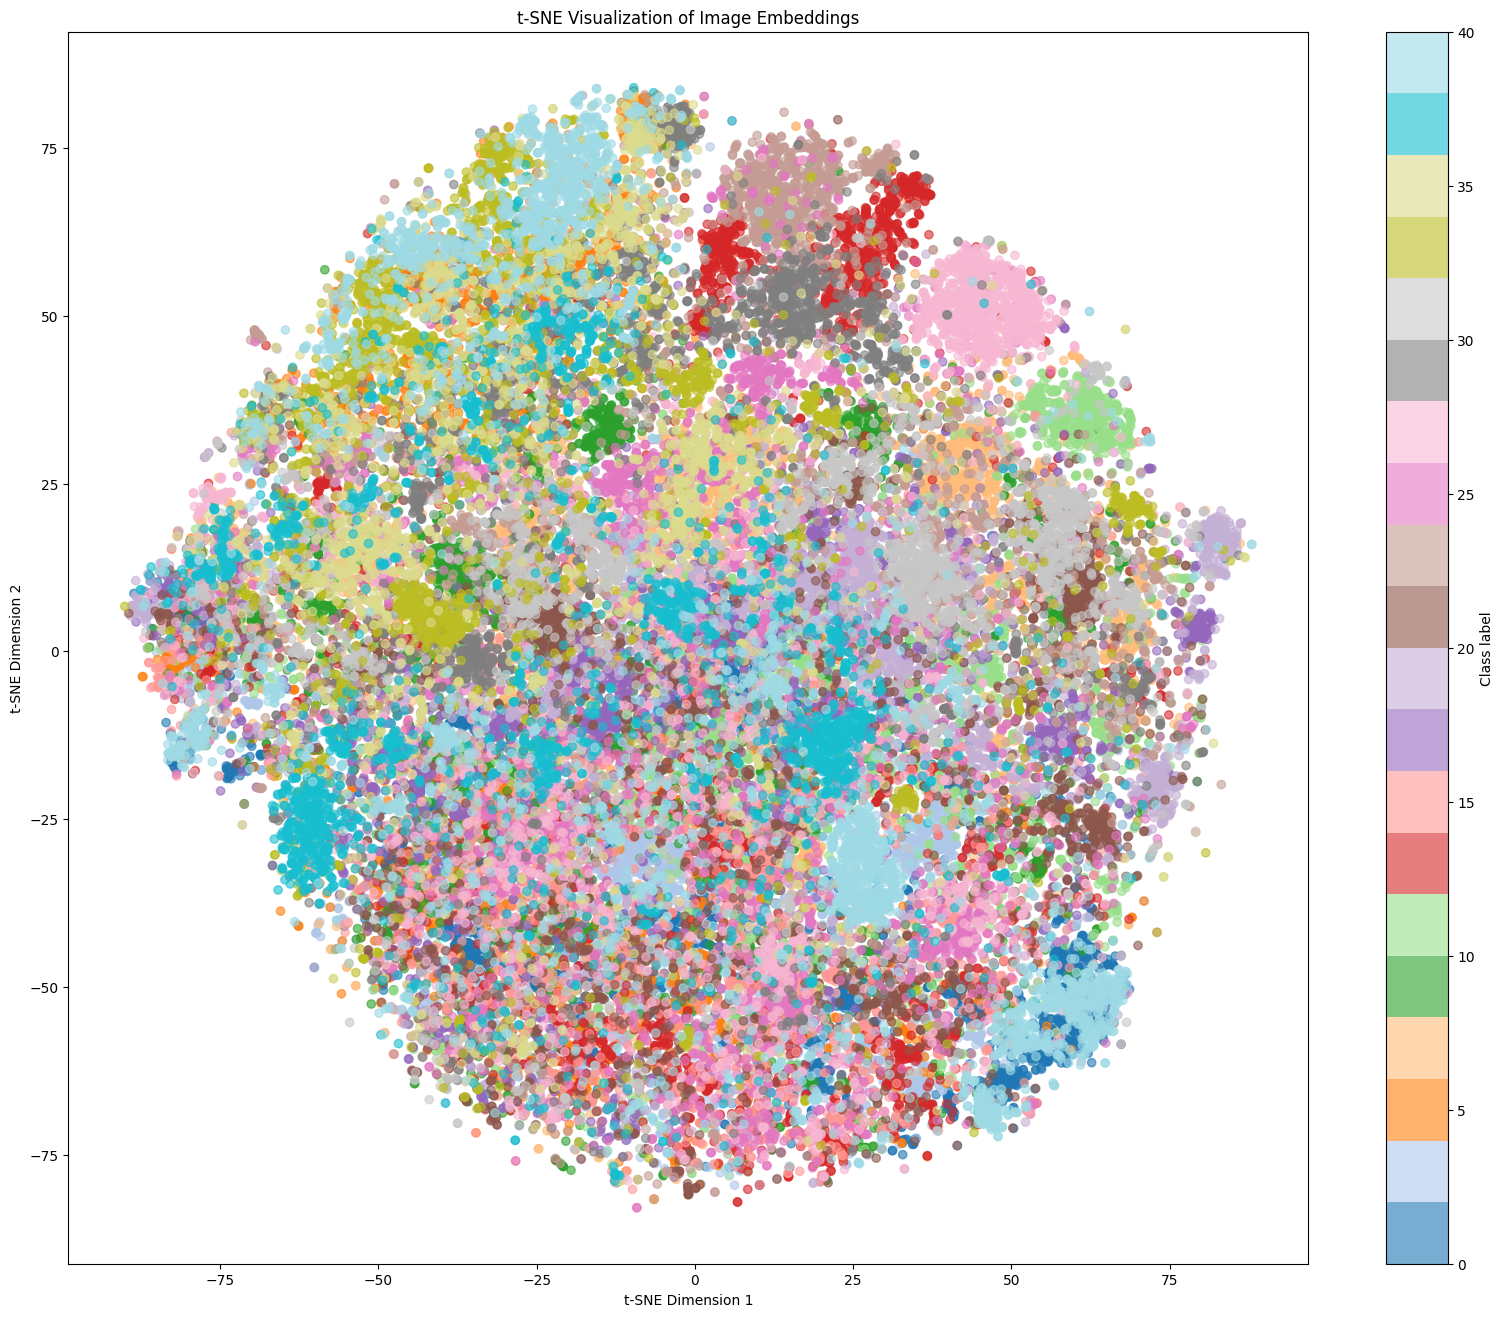

In [4]:
# # Cell 4: Visualize the Embedding Space (Using PCA and t-SNE)

# # Apply PCA to reduce dimensionality (for faster t-SNE)
# pca = PCA(n_components=50)
# embeddings_pca = pca.fit_transform(embeddings)

# # Then apply t-SNE to reduce to 2 dimensions for visualization
# tsne = TSNE(n_components=2, random_state=42)
# embeddings_tsne = tsne.fit_transform(embeddings_pca)

# # Plot t-SNE embedding with different colors for each class
# plt.figure(figsize=(20, 16))
# scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=all_labels, cmap='tab20', alpha=0.6)
# plt.colorbar(scatter, label="Class label")
# plt.title("t-SNE Visualization of Image Embeddings")
# plt.xlabel("t-SNE Dimension 1")
# plt.ylabel("t-SNE Dimension 2")
# plt.show()

# Visualize the Embedding Space in 3-D

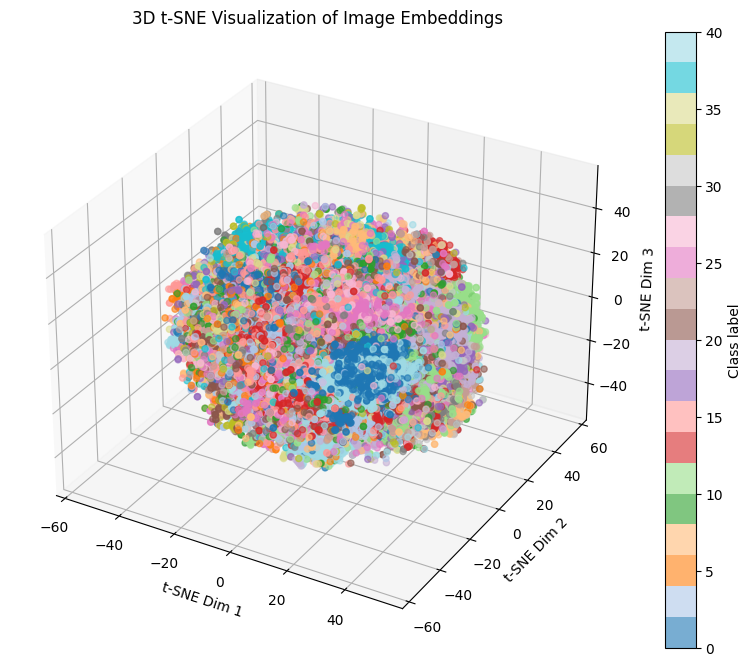

In [5]:
# from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting

# # First, reduce dimensionality with PCA (still using 50 components for speed)
# pca = PCA(n_components=50)
# embeddings_pca = pca.fit_transform(embeddings)

# # Apply t-SNE with 3 components for 3D visualization
# tsne = TSNE(n_components=3, random_state=42)
# embeddings_tsne = tsne.fit_transform(embeddings_pca)

# # Plot the 3D t-SNE embeddings, colored by class label
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# scatter = ax.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], embeddings_tsne[:, 2],
#                      c=all_labels, cmap='tab20', alpha=0.6)
# fig.colorbar(scatter, ax=ax, label="Class label")
# ax.set_title("3D t-SNE Visualization of Image Embeddings")
# ax.set_xlabel("t-SNE Dim 1")
# ax.set_ylabel("t-SNE Dim 2")
# ax.set_zlabel("t-SNE Dim 3")
# plt.show()

# Compute Difficulty Score Per Image


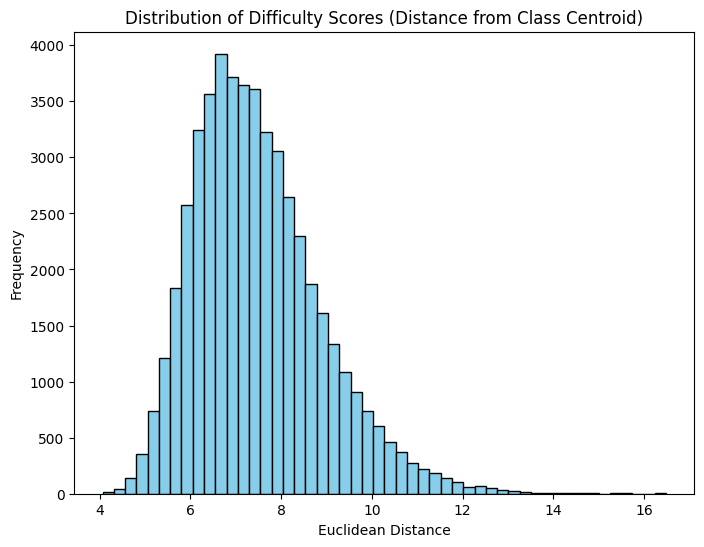

In [7]:
# Cell 5: Compute Difficulty Score Per Image

# For each class, compute the centroid (mean embedding) and then compute Euclidean distance of each sample to its class centroid.
difficulty_scores = np.zeros(len(embeddings))

for class_idx in np.unique(labels):
    # Get indices of all samples for this class
    class_indices = np.where(labels == class_idx)[0]
    class_embeddings = embeddings[class_indices]
    # Compute centroid of this class
    centroid = np.mean(class_embeddings, axis=0, keepdims=True)
    # Compute Euclidean distance from each sample to the centroid
    distances = np.linalg.norm(class_embeddings - centroid, axis=1)
    difficulty_scores[class_indices] = distances

# Plot overall distribution of difficulty scores
plt.figure(figsize=(8, 6))
plt.hist(difficulty_scores, bins=50, color='skyblue', edgecolor='k')
plt.title("Distribution of Difficulty Scores (Distance from Class Centroid)")
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")
plt.show()

# Train/Test Split with Stratification (By Class Labels)


In [8]:
# Cell 6: Train/Test Split with Stratification (By Class Labels)

# Use StratifiedShuffleSplit to ensure each class is proportionately represented in train and test.
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1337)
train_idx, test_idx = next(sss.split(np.zeros(len(labels)), labels))  # np.zeros(len(labels)) is a dummy variable

# Create subsets for training and testing using the indices
from torch.utils.data import Subset
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

print("Training samples:", len(train_dataset))
print("Testing samples:", len(test_dataset))

Training samples: 40016
Testing samples: 10004


# Verify Difficulty Distribution in Train and Test


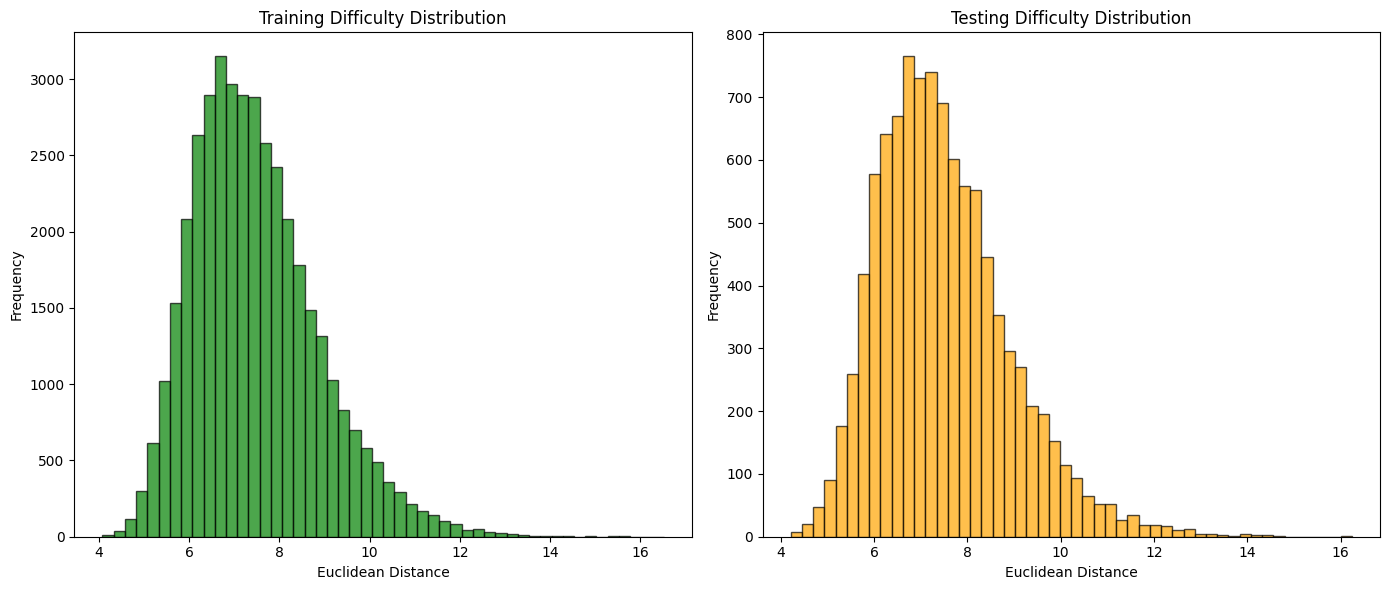

In [9]:
# Cell 7: Verify Difficulty Distribution in Train and Test

# Create DataLoaders for embedding computation for train and test subsets
train_loader_embed = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader_embed = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

def compute_difficulty_for_subset(loader, feature_extractor):
    subset_embeddings = []
    subset_indices = []  # to align with the original difficulty scores
    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            feat = feature_extractor(inputs)
            subset_embeddings.append(feat.cpu().numpy())
    return np.vstack(subset_embeddings)

# Compute embeddings for train and test
train_embeddings = compute_difficulty_for_subset(train_loader_embed, feature_extractor)
test_embeddings = compute_difficulty_for_subset(test_loader_embed, feature_extractor)

# Get labels for train and test subsets (using dataset.samples)
train_labels = [dataset.samples[i][1] for i in train_idx]
test_labels = [dataset.samples[i][1] for i in test_idx]

# Compute difficulty scores for train and test by reusing the method in Cell 5
def compute_difficulty(embeddings, labels):
    diff_scores = np.zeros(len(embeddings))
    for class_idx in np.unique(labels):
        indices = np.where(np.array(labels) == class_idx)[0]
        class_embeds = embeddings[indices]
        centroid = np.mean(class_embeds, axis=0, keepdims=True)
        distances = np.linalg.norm(class_embeds - centroid, axis=1)
        diff_scores[indices] = distances
    return diff_scores

train_difficulty = compute_difficulty(train_embeddings, train_labels)
test_difficulty = compute_difficulty(test_embeddings, test_labels)

# Plot histograms to compare
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(train_difficulty, bins=50, color='green', alpha=0.7, edgecolor='k')
plt.title("Training Difficulty Distribution")
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(test_difficulty, bins=50, color='orange', alpha=0.7, edgecolor='k')
plt.title("Testing Difficulty Distribution")
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Different Train Test Split random_state=1553

In [10]:
# Cell 6: Train/Test Split with Stratification (By Class Labels)

# Use StratifiedShuffleSplit to ensure each class is proportionately represented in train and test.
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1553)
train_idx, test_idx = next(sss.split(np.zeros(len(labels)), labels))  # np.zeros(len(labels)) is a dummy variable

# Create subsets for training and testing using the indices
from torch.utils.data import Subset
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

print("Training samples:", len(train_dataset))
print("Testing samples:", len(test_dataset))

Training samples: 40016
Testing samples: 10004


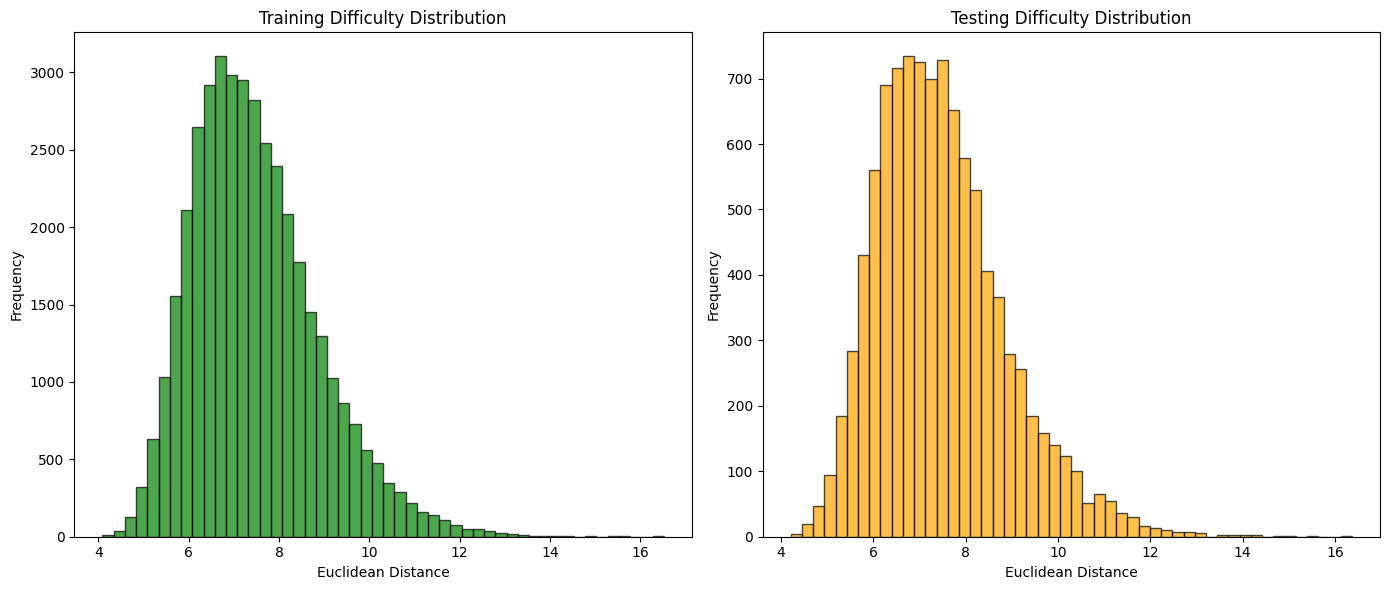

In [11]:
# Cell 7: Verify Difficulty Distribution in Train and Test

# Create DataLoaders for embedding computation for train and test subsets
train_loader_embed = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader_embed = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

def compute_difficulty_for_subset(loader, feature_extractor):
    subset_embeddings = []
    subset_indices = []  # to align with the original difficulty scores
    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            feat = feature_extractor(inputs)
            subset_embeddings.append(feat.cpu().numpy())
    return np.vstack(subset_embeddings)

# Compute embeddings for train and test
train_embeddings = compute_difficulty_for_subset(train_loader_embed, feature_extractor)
test_embeddings = compute_difficulty_for_subset(test_loader_embed, feature_extractor)

# Get labels for train and test subsets (using dataset.samples)
train_labels = [dataset.samples[i][1] for i in train_idx]
test_labels = [dataset.samples[i][1] for i in test_idx]

# Compute difficulty scores for train and test by reusing the method in Cell 5
def compute_difficulty(embeddings, labels):
    diff_scores = np.zeros(len(embeddings))
    for class_idx in np.unique(labels):
        indices = np.where(np.array(labels) == class_idx)[0]
        class_embeds = embeddings[indices]
        centroid = np.mean(class_embeds, axis=0, keepdims=True)
        distances = np.linalg.norm(class_embeds - centroid, axis=1)
        diff_scores[indices] = distances
    return diff_scores

train_difficulty = compute_difficulty(train_embeddings, train_labels)
test_difficulty = compute_difficulty(test_embeddings, test_labels)

# Plot histograms to compare
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(train_difficulty, bins=50, color='green', alpha=0.7, edgecolor='k')
plt.title("Training Difficulty Distribution")
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(test_difficulty, bins=50, color='orange', alpha=0.7, edgecolor='k')
plt.title("Testing Difficulty Distribution")
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Different Train Test Split random_state=837

In [12]:
# Cell 6: Train/Test Split with Stratification (By Class Labels)

# Use StratifiedShuffleSplit to ensure each class is proportionately represented in train and test.
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=837)
train_idx, test_idx = next(sss.split(np.zeros(len(labels)), labels))  # np.zeros(len(labels)) is a dummy variable

# Create subsets for training and testing using the indices
from torch.utils.data import Subset
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

print("Training samples:", len(train_dataset))
print("Testing samples:", len(test_dataset))

Training samples: 40016
Testing samples: 10004


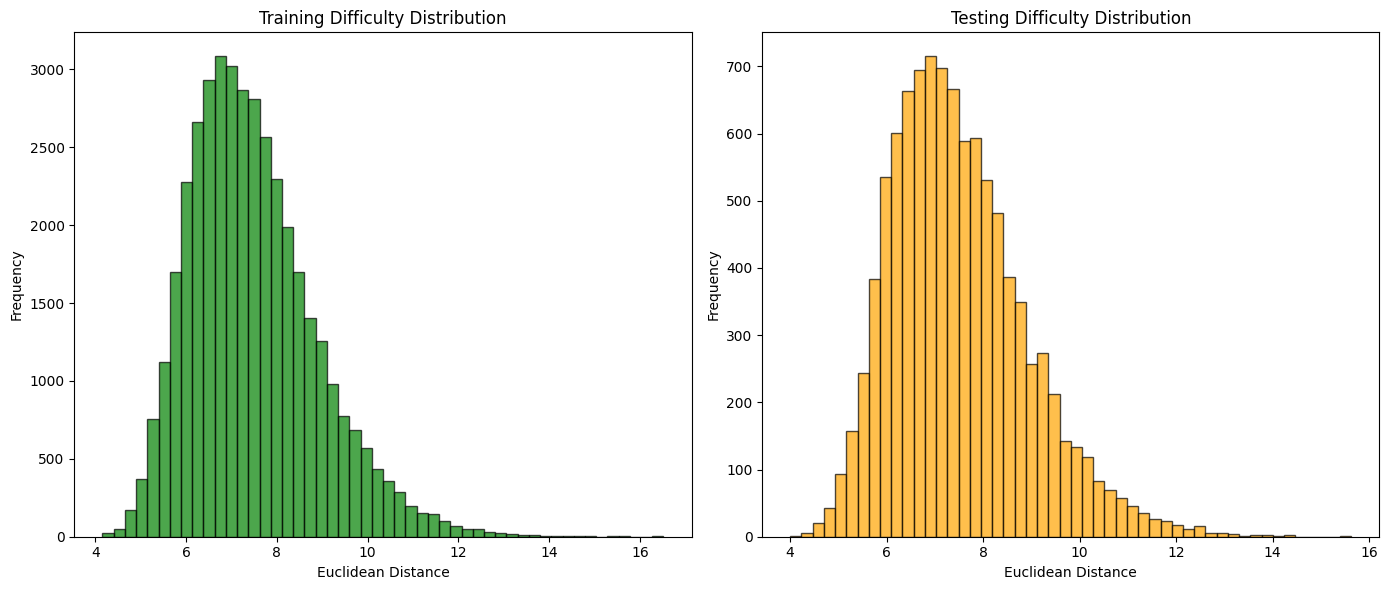

In [13]:
# Cell 7: Verify Difficulty Distribution in Train and Test

# Create DataLoaders for embedding computation for train and test subsets
train_loader_embed = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader_embed = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

def compute_difficulty_for_subset(loader, feature_extractor):
    subset_embeddings = []
    subset_indices = []  # to align with the original difficulty scores
    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            feat = feature_extractor(inputs)
            subset_embeddings.append(feat.cpu().numpy())
    return np.vstack(subset_embeddings)

# Compute embeddings for train and test
train_embeddings = compute_difficulty_for_subset(train_loader_embed, feature_extractor)
test_embeddings = compute_difficulty_for_subset(test_loader_embed, feature_extractor)

# Get labels for train and test subsets (using dataset.samples)
train_labels = [dataset.samples[i][1] for i in train_idx]
test_labels = [dataset.samples[i][1] for i in test_idx]

# Compute difficulty scores for train and test by reusing the method in Cell 5
def compute_difficulty(embeddings, labels):
    diff_scores = np.zeros(len(embeddings))
    for class_idx in np.unique(labels):
        indices = np.where(np.array(labels) == class_idx)[0]
        class_embeds = embeddings[indices]
        centroid = np.mean(class_embeds, axis=0, keepdims=True)
        distances = np.linalg.norm(class_embeds - centroid, axis=1)
        diff_scores[indices] = distances
    return diff_scores

train_difficulty = compute_difficulty(train_embeddings, train_labels)
test_difficulty = compute_difficulty(test_embeddings, test_labels)

# Plot histograms to compare
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(train_difficulty, bins=50, color='green', alpha=0.7, edgecolor='k')
plt.title("Training Difficulty Distribution")
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(test_difficulty, bins=50, color='orange', alpha=0.7, edgecolor='k')
plt.title("Testing Difficulty Distribution")
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Different Train Test Split random_state=735

In [16]:
# Cell 6: Train/Test Split with Stratification (By Class Labels)

# Use StratifiedShuffleSplit to ensure each class is proportionately represented in train and test.
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=735)
train_idx, test_idx = next(sss.split(np.zeros(len(labels)), labels))  # np.zeros(len(labels)) is a dummy variable

# Create subsets for training and testing using the indices
from torch.utils.data import Subset
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

print("Training samples:", len(train_dataset))
print("Testing samples:", len(test_dataset))

Training samples: 40016
Testing samples: 10004


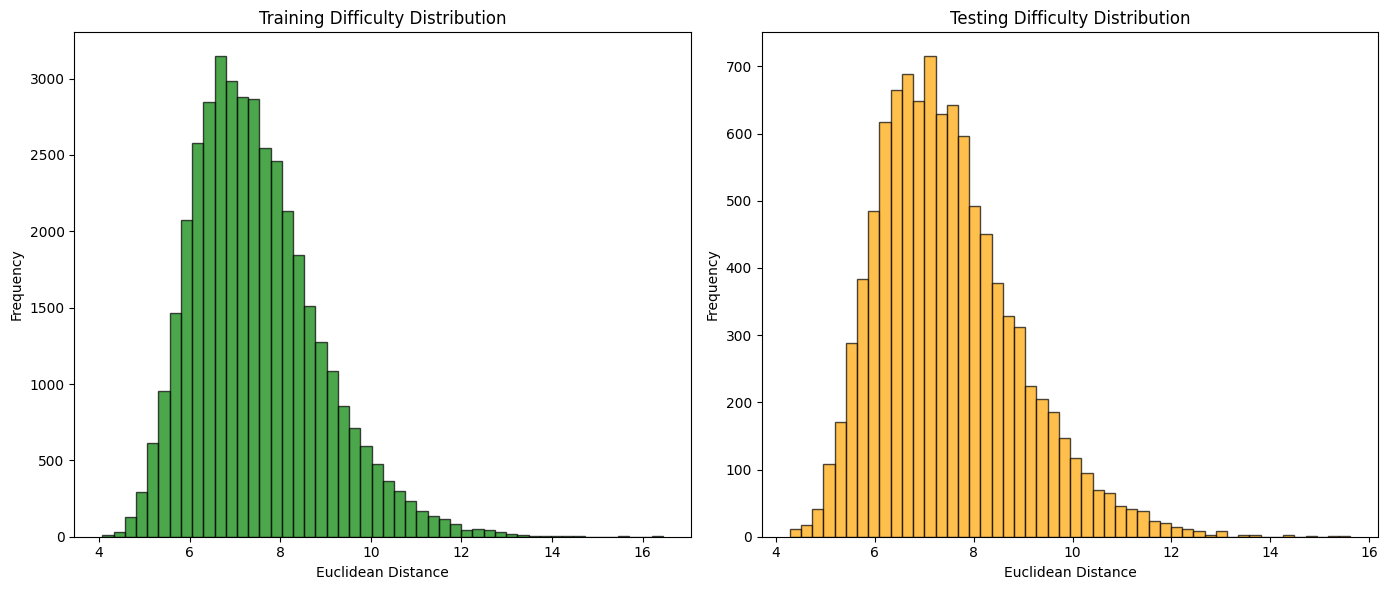

In [17]:
# Cell 7: Verify Difficulty Distribution in Train and Test

# Create DataLoaders for embedding computation for train and test subsets
train_loader_embed = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader_embed = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

def compute_difficulty_for_subset(loader, feature_extractor):
    subset_embeddings = []
    subset_indices = []  # to align with the original difficulty scores
    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            feat = feature_extractor(inputs)
            subset_embeddings.append(feat.cpu().numpy())
    return np.vstack(subset_embeddings)

# Compute embeddings for train and test
train_embeddings = compute_difficulty_for_subset(train_loader_embed, feature_extractor)
test_embeddings = compute_difficulty_for_subset(test_loader_embed, feature_extractor)

# Get labels for train and test subsets (using dataset.samples)
train_labels = [dataset.samples[i][1] for i in train_idx]
test_labels = [dataset.samples[i][1] for i in test_idx]

# Compute difficulty scores for train and test by reusing the method in Cell 5
def compute_difficulty(embeddings, labels):
    diff_scores = np.zeros(len(embeddings))
    for class_idx in np.unique(labels):
        indices = np.where(np.array(labels) == class_idx)[0]
        class_embeds = embeddings[indices]
        centroid = np.mean(class_embeds, axis=0, keepdims=True)
        distances = np.linalg.norm(class_embeds - centroid, axis=1)
        diff_scores[indices] = distances
    return diff_scores

train_difficulty = compute_difficulty(train_embeddings, train_labels)
test_difficulty = compute_difficulty(test_embeddings, test_labels)

# Plot histograms to compare
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(train_difficulty, bins=50, color='green', alpha=0.7, edgecolor='k')
plt.title("Training Difficulty Distribution")
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(test_difficulty, bins=50, color='orange', alpha=0.7, edgecolor='k')
plt.title("Testing Difficulty Distribution")
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Different Train Test Split random_state=231

In [18]:
# Cell 6: Train/Test Split with Stratification (By Class Labels)

# Use StratifiedShuffleSplit to ensure each class is proportionately represented in train and test.
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=231)
train_idx, test_idx = next(sss.split(np.zeros(len(labels)), labels))  # np.zeros(len(labels)) is a dummy variable

# Create subsets for training and testing using the indices
from torch.utils.data import Subset
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

print("Training samples:", len(train_dataset))
print("Testing samples:", len(test_dataset))

Training samples: 40016
Testing samples: 10004


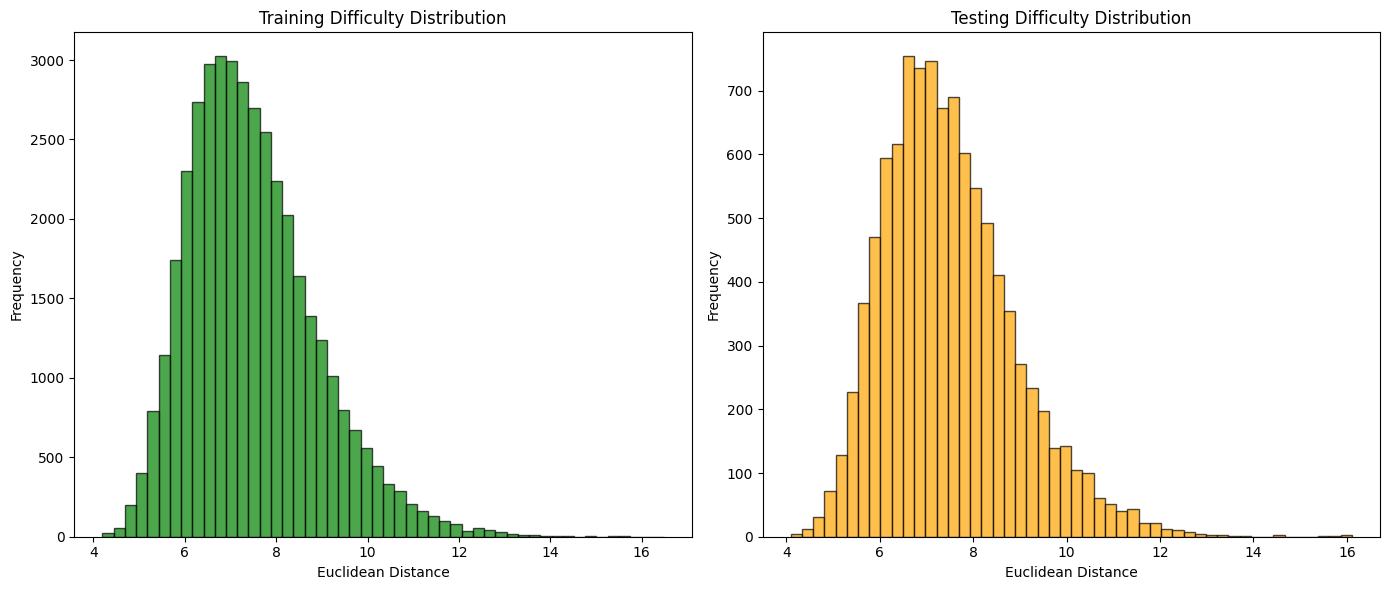

In [19]:
# Cell 7: Verify Difficulty Distribution in Train and Test

# Create DataLoaders for embedding computation for train and test subsets
train_loader_embed = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader_embed = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

def compute_difficulty_for_subset(loader, feature_extractor):
    subset_embeddings = []
    subset_indices = []  # to align with the original difficulty scores
    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            feat = feature_extractor(inputs)
            subset_embeddings.append(feat.cpu().numpy())
    return np.vstack(subset_embeddings)

# Compute embeddings for train and test
train_embeddings = compute_difficulty_for_subset(train_loader_embed, feature_extractor)
test_embeddings = compute_difficulty_for_subset(test_loader_embed, feature_extractor)

# Get labels for train and test subsets (using dataset.samples)
train_labels = [dataset.samples[i][1] for i in train_idx]
test_labels = [dataset.samples[i][1] for i in test_idx]

# Compute difficulty scores for train and test by reusing the method in Cell 5
def compute_difficulty(embeddings, labels):
    diff_scores = np.zeros(len(embeddings))
    for class_idx in np.unique(labels):
        indices = np.where(np.array(labels) == class_idx)[0]
        class_embeds = embeddings[indices]
        centroid = np.mean(class_embeds, axis=0, keepdims=True)
        distances = np.linalg.norm(class_embeds - centroid, axis=1)
        diff_scores[indices] = distances
    return diff_scores

train_difficulty = compute_difficulty(train_embeddings, train_labels)
test_difficulty = compute_difficulty(test_embeddings, test_labels)

# Plot histograms to compare
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(train_difficulty, bins=50, color='green', alpha=0.7, edgecolor='k')
plt.title("Training Difficulty Distribution")
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(test_difficulty, bins=50, color='orange', alpha=0.7, edgecolor='k')
plt.title("Testing Difficulty Distribution")
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Iterate Over 15 random seed values


--- Random Seed: 42 ---
Training samples: 40016
Testing samples: 10004


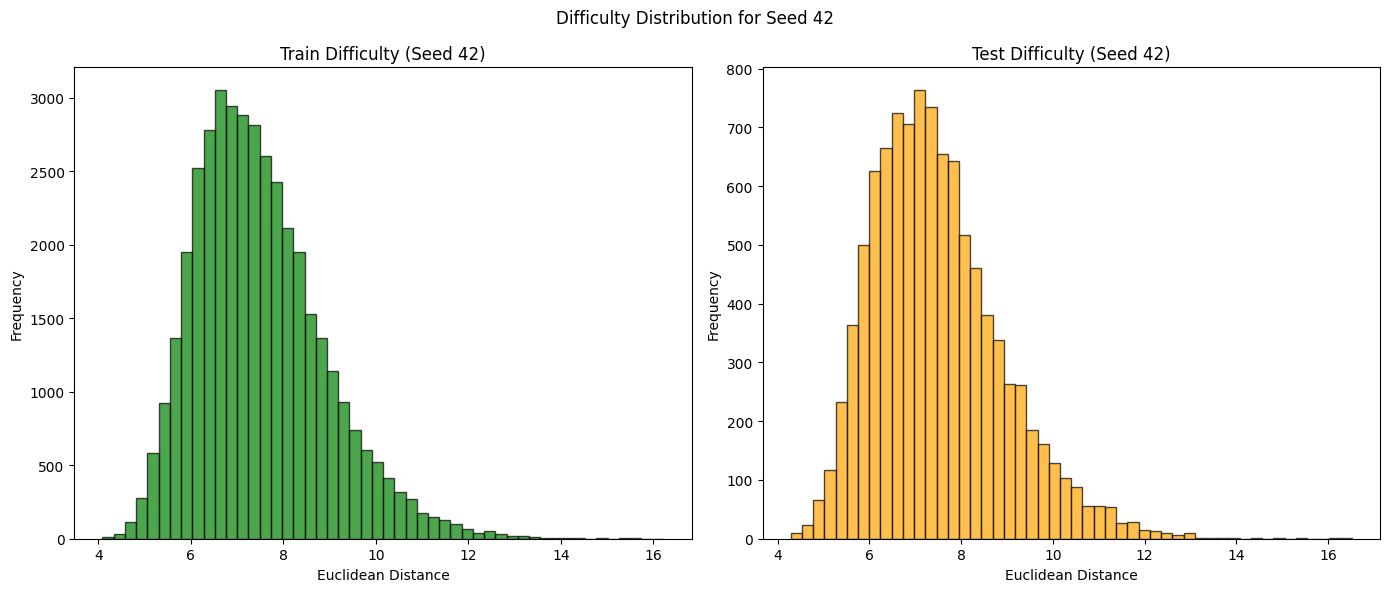


--- Random Seed: 123 ---
Training samples: 40016
Testing samples: 10004


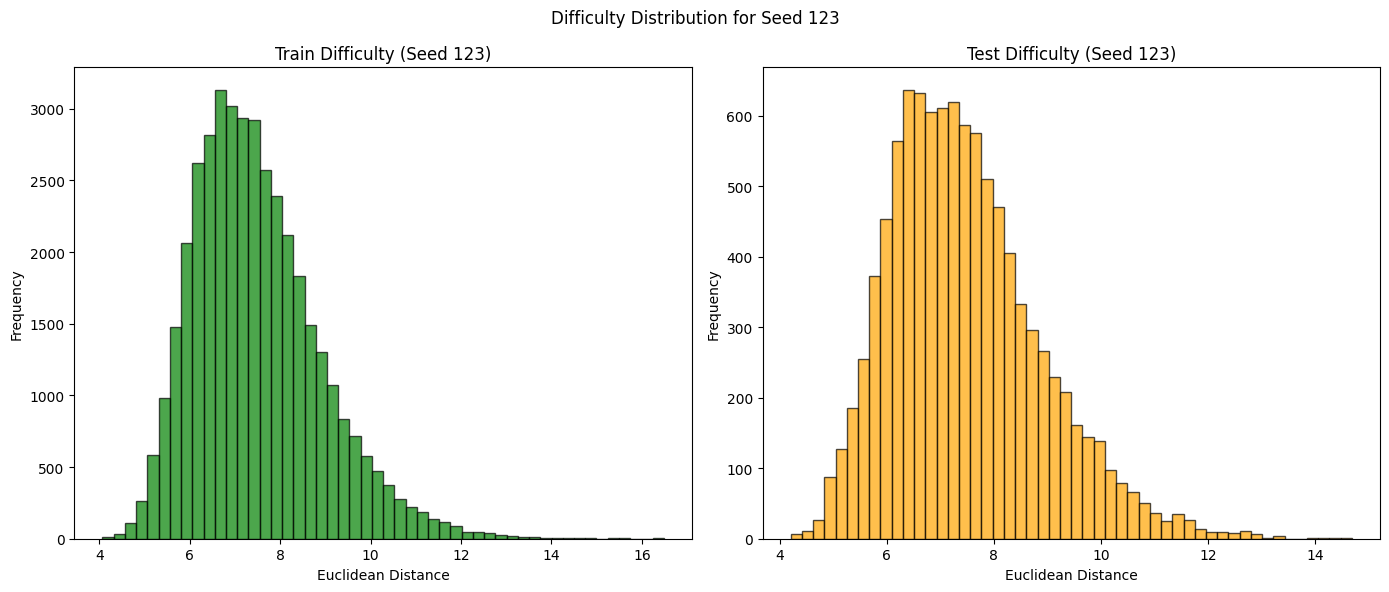


--- Random Seed: 231 ---
Training samples: 40016
Testing samples: 10004


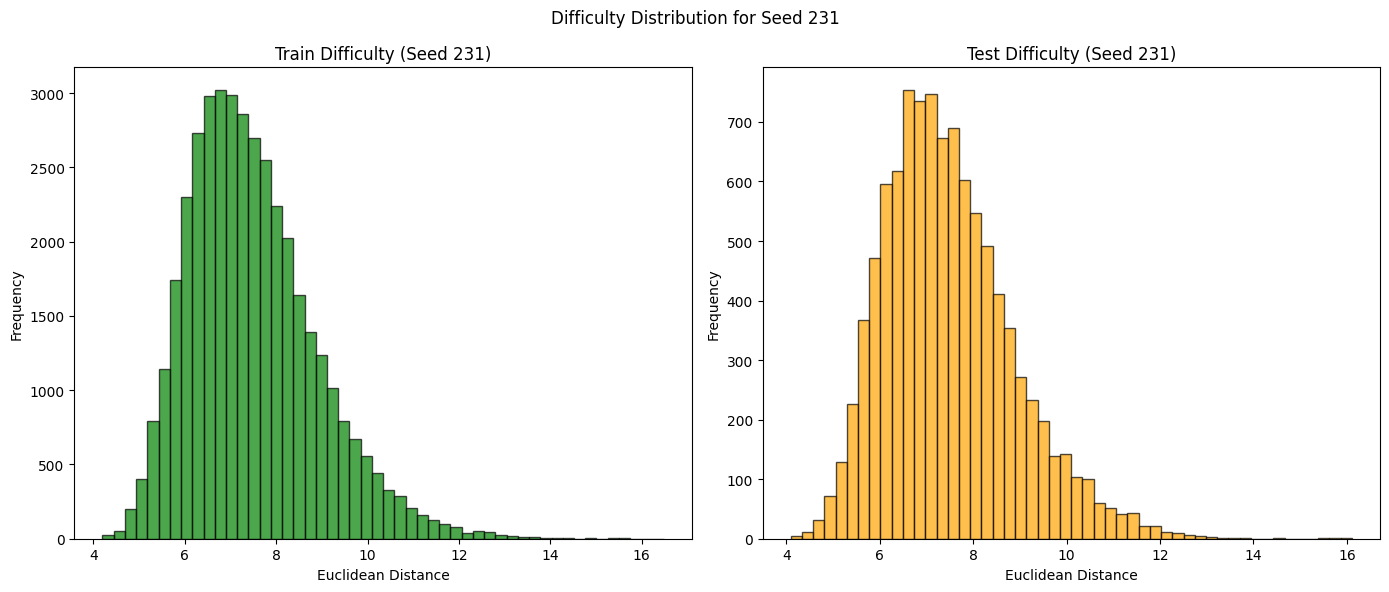


--- Random Seed: 17 ---
Training samples: 40016
Testing samples: 10004


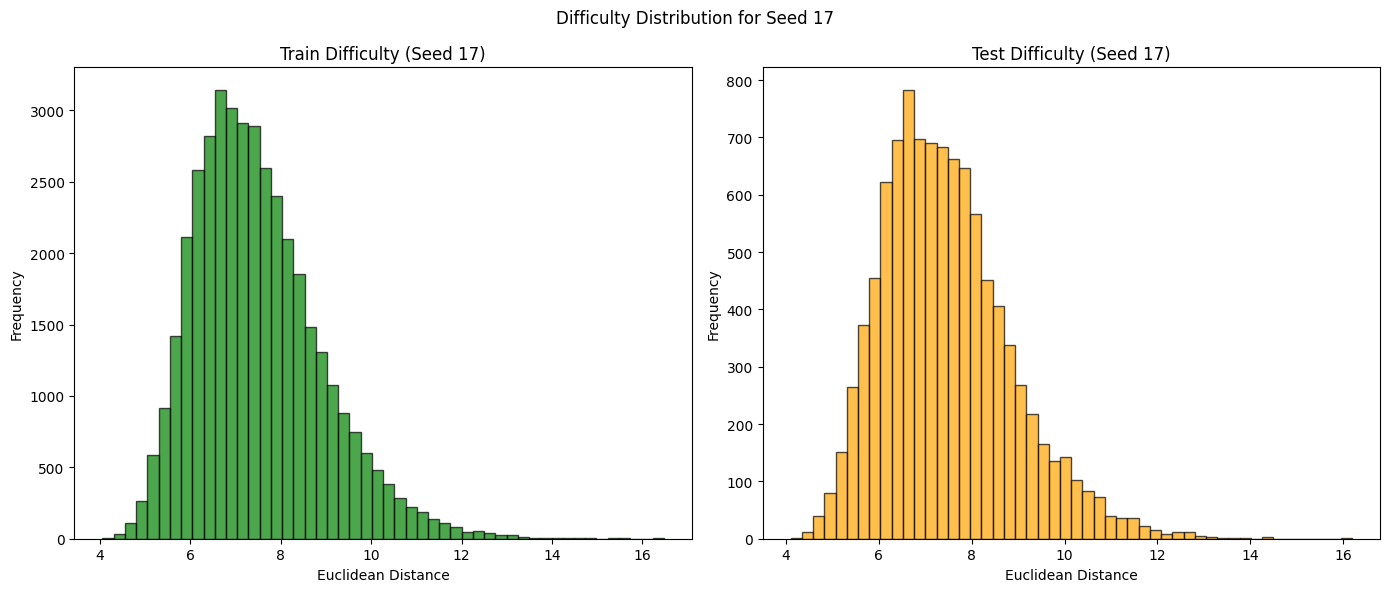


--- Random Seed: 99 ---
Training samples: 40016
Testing samples: 10004


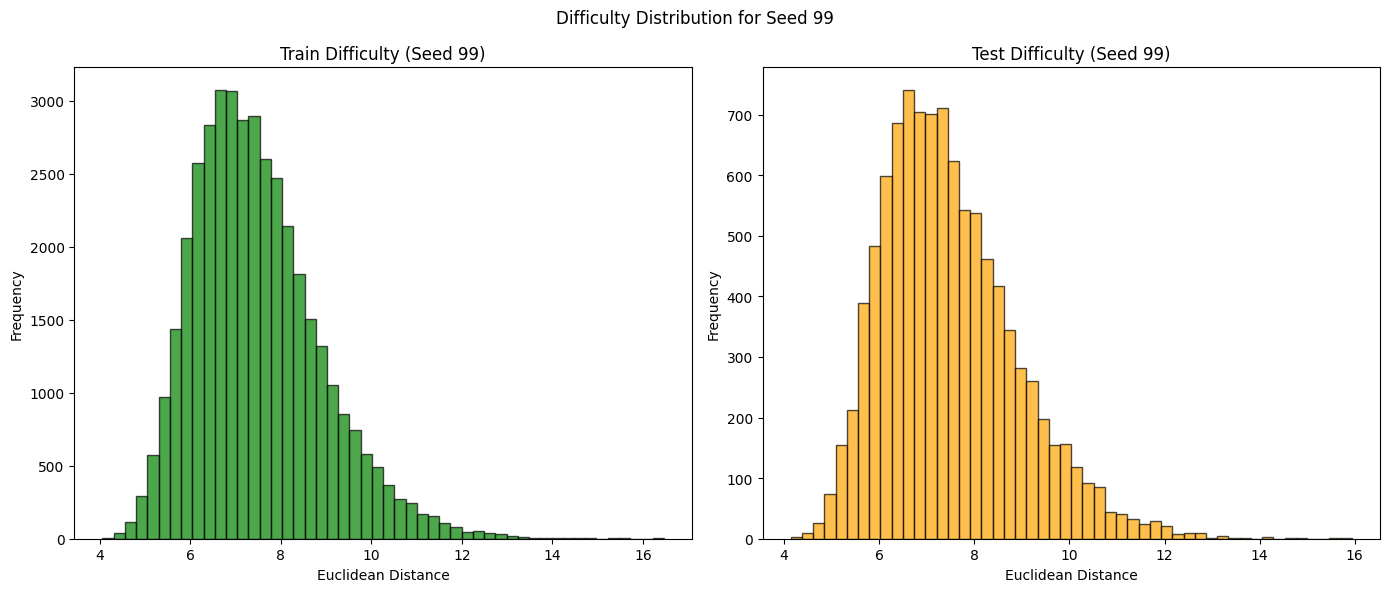


--- Random Seed: 101 ---
Training samples: 40016
Testing samples: 10004


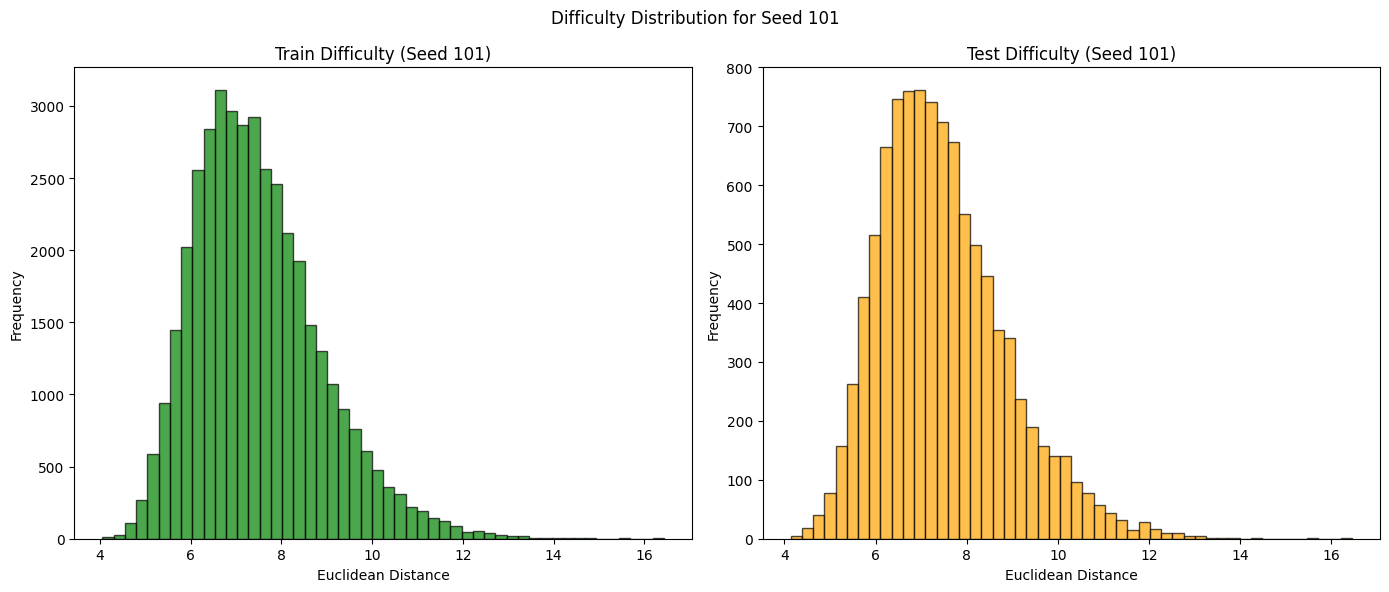


--- Random Seed: 202 ---
Training samples: 40016
Testing samples: 10004


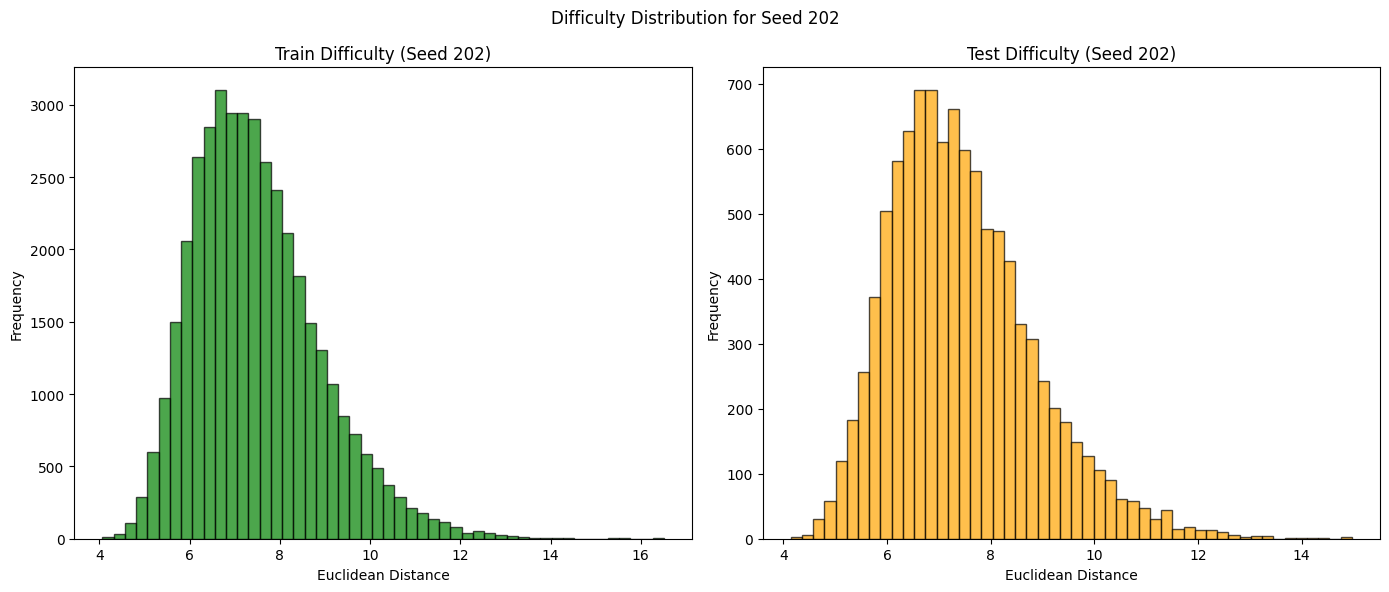


--- Random Seed: 303 ---
Training samples: 40016
Testing samples: 10004


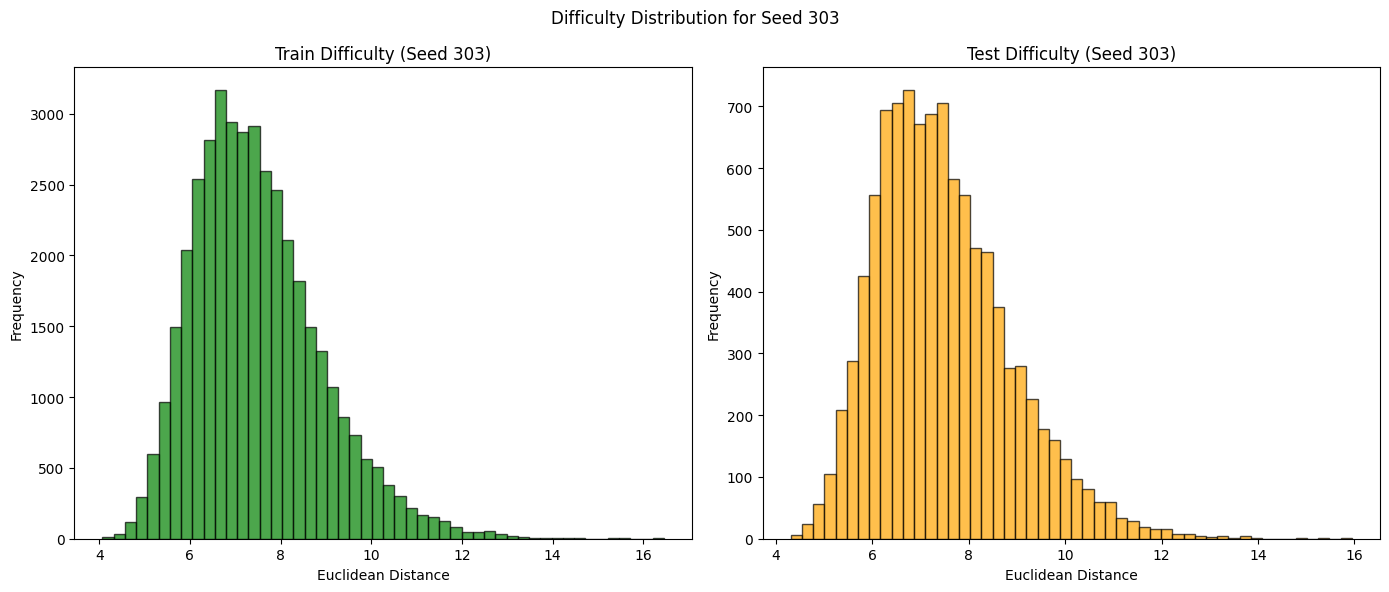


--- Random Seed: 404 ---
Training samples: 40016
Testing samples: 10004


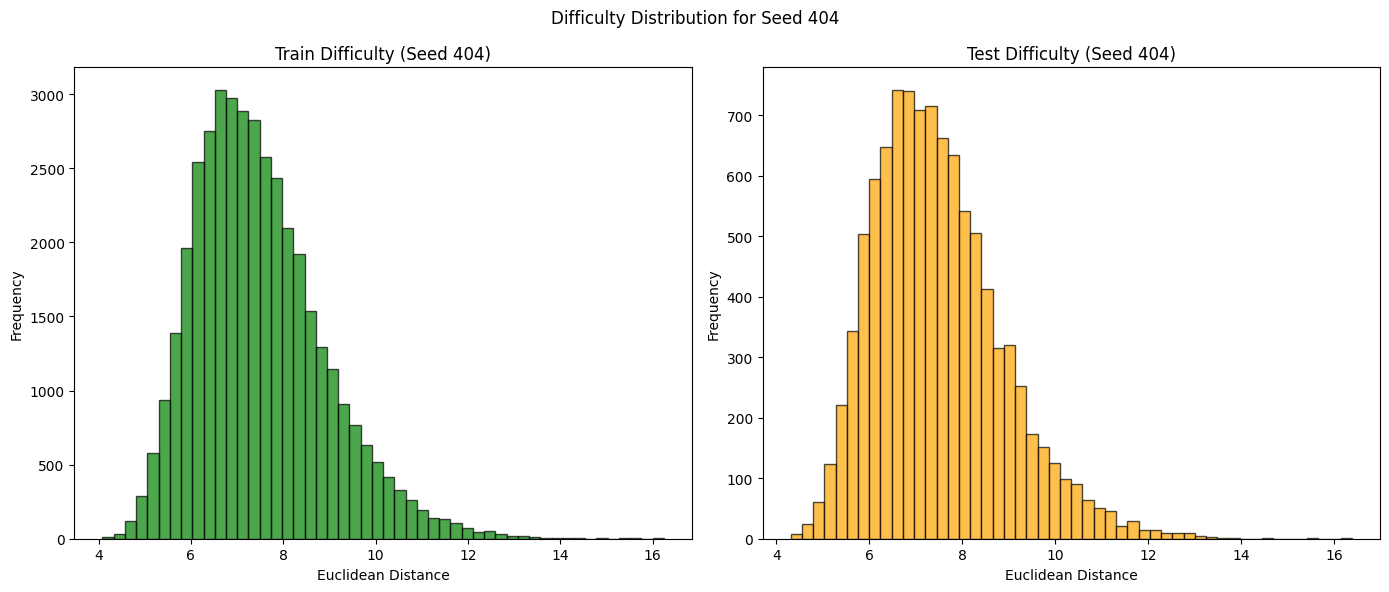


--- Random Seed: 505 ---
Training samples: 40016
Testing samples: 10004


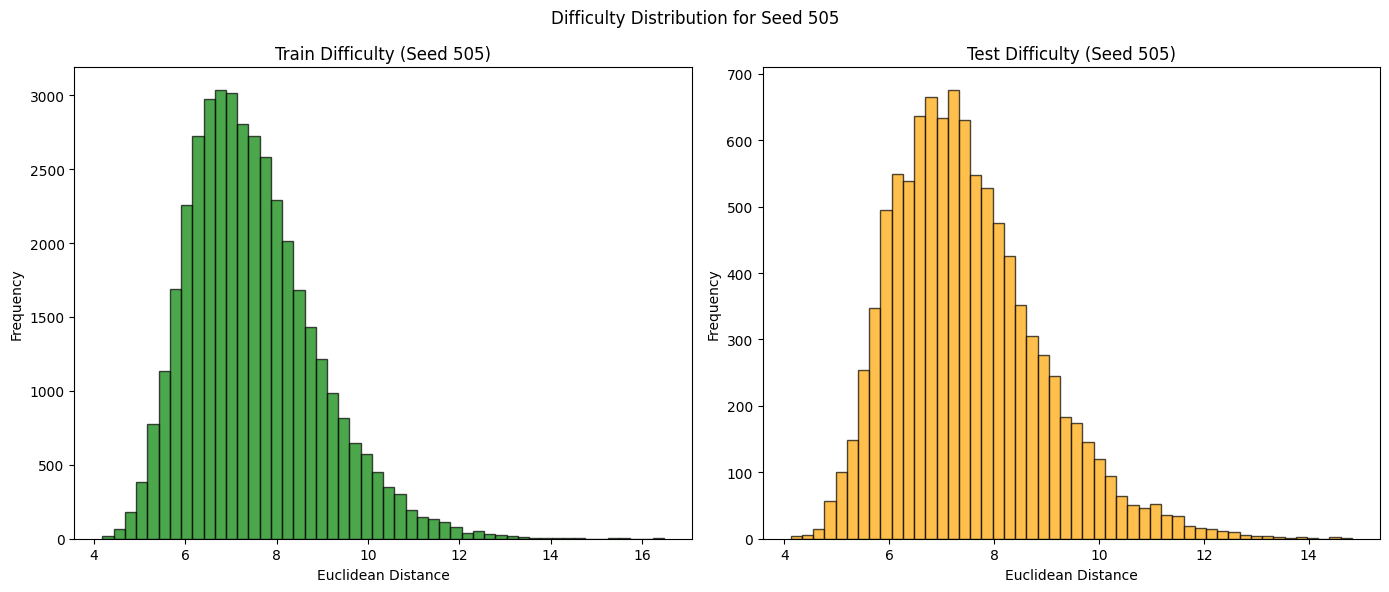


--- Random Seed: 606 ---
Training samples: 40016
Testing samples: 10004


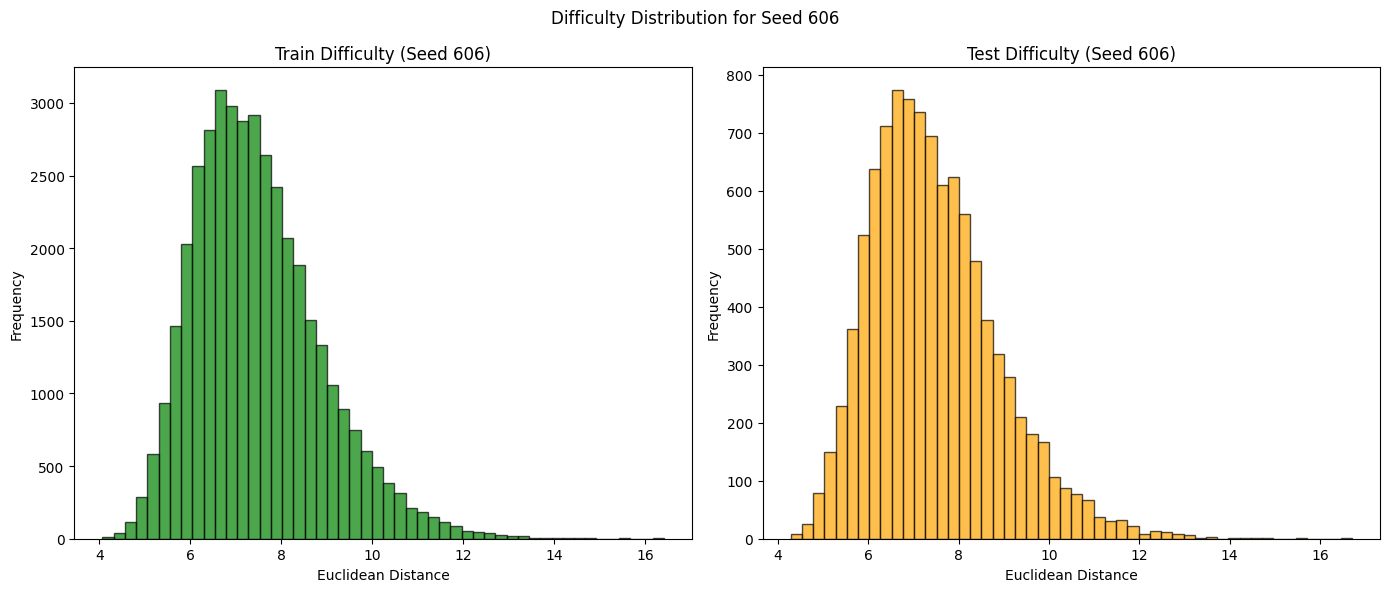


--- Random Seed: 707 ---
Training samples: 40016
Testing samples: 10004


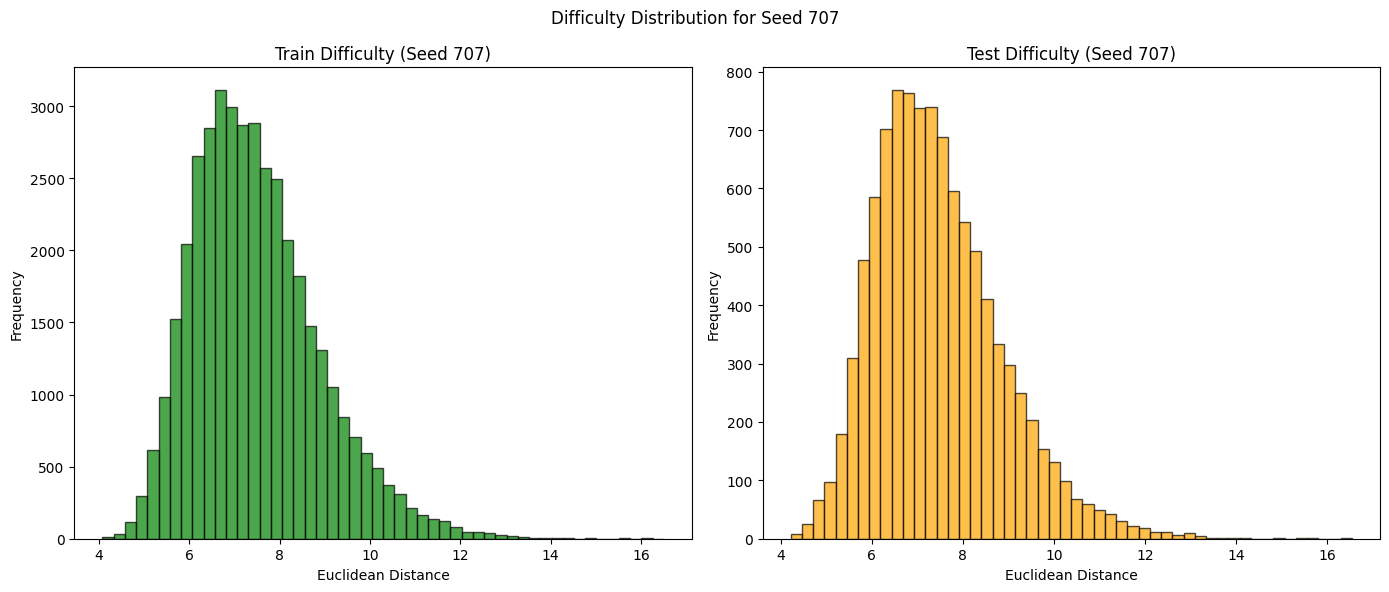


--- Random Seed: 808 ---
Training samples: 40016
Testing samples: 10004


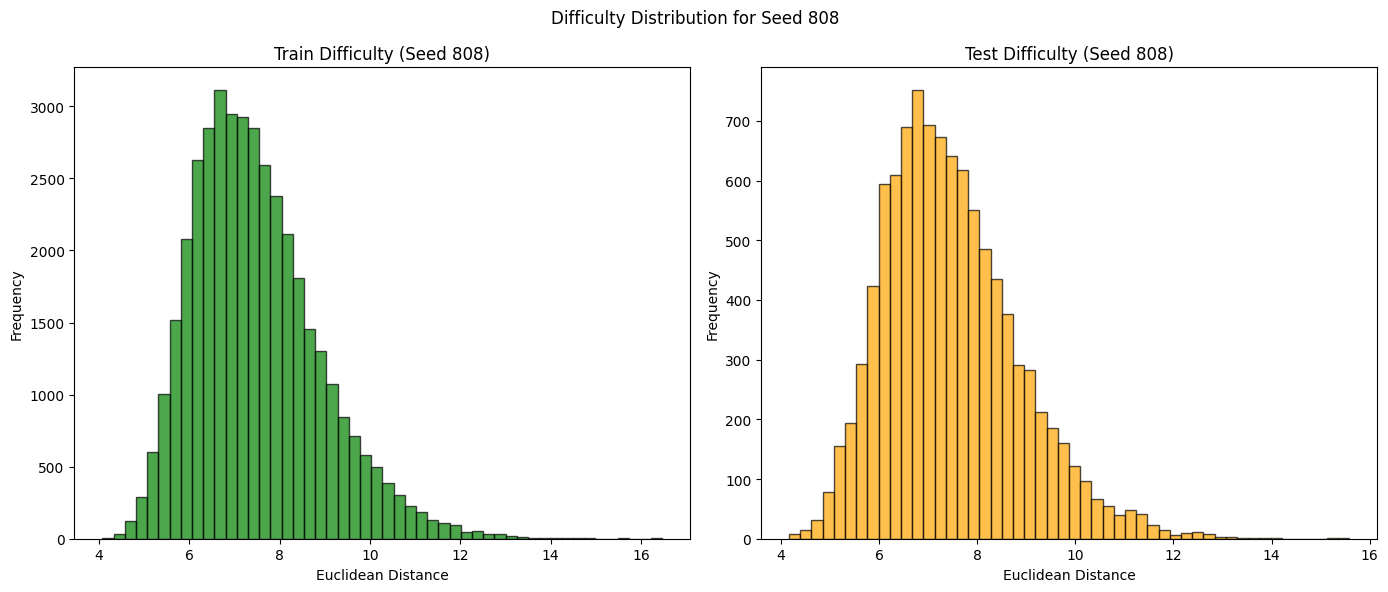


--- Random Seed: 909 ---
Training samples: 40016
Testing samples: 10004


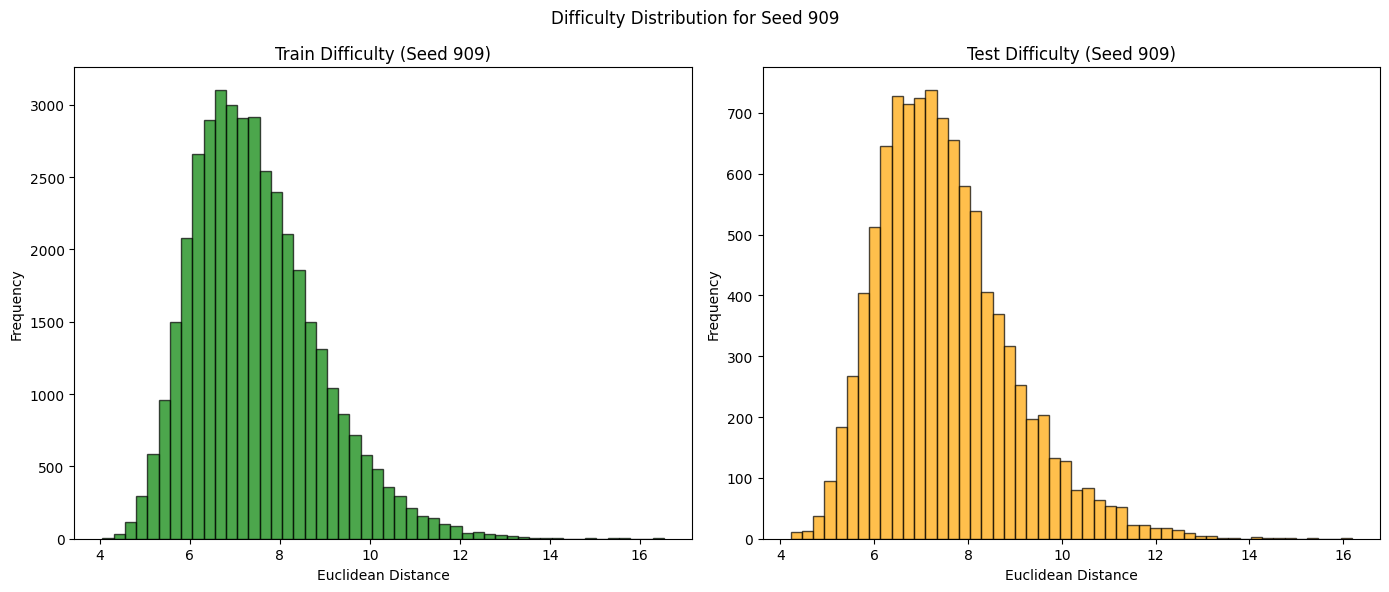


--- Random Seed: 1001 ---
Training samples: 40016
Testing samples: 10004


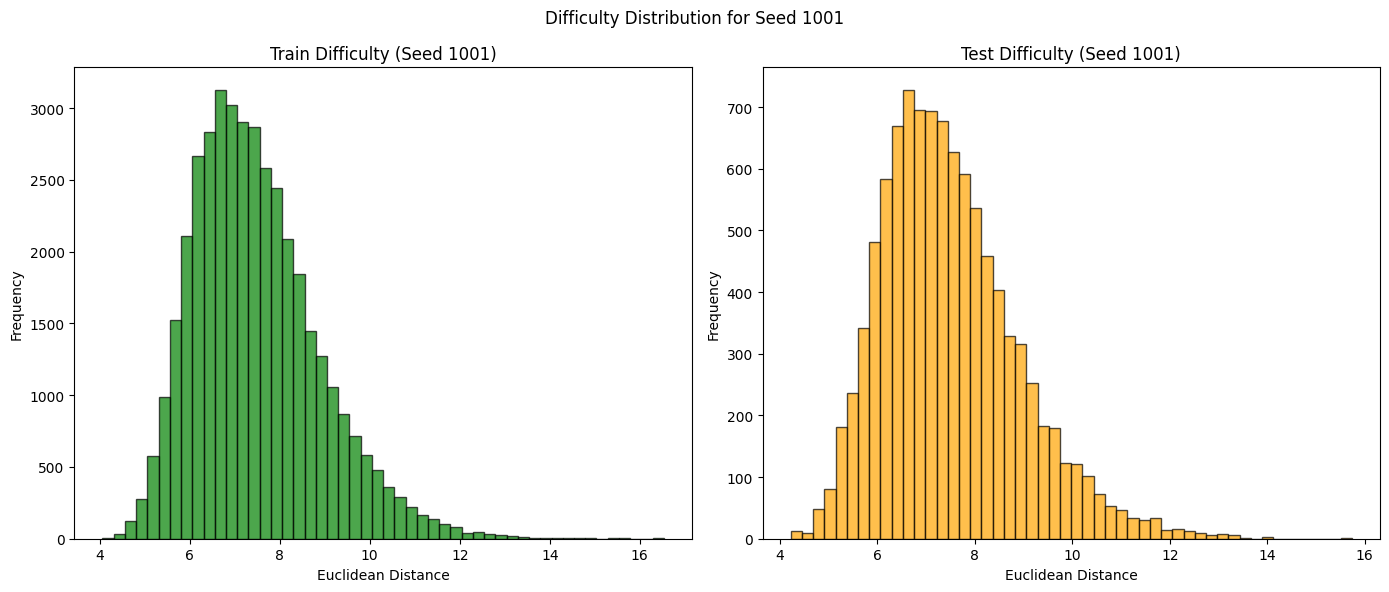

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset

# Assume these variables are already defined in previous cells:
# - dataset (a PyTorch ImageFolder dataset)
# - labels: a numpy array of class labels for each image, e.g.,
#      labels = np.array([s[1] for s in dataset.samples])
# - feature_extractor: a pretrained model (e.g., ResNet) wrapped with DataParallel if available
# - device: already set (e.g., torch.device("cuda") if available)
# - compute_difficulty_for_subset(loader, feature_extractor): function that returns embeddings for a given loader
# - compute_difficulty(embeddings, labels): function that computes Euclidean distance from the class centroid

# List of 15 pre-defined random seeds (rule-of-thumb seeds)
seed_list = [42, 123, 231, 17, 99, 101, 202, 303, 404, 505, 606, 707, 808, 909, 1001]

# For each seed, we will perform a stratified split and plot the difficulty distributions.
for seed in seed_list:
    print(f"\n--- Random Seed: {seed} ---")
    
    # Create StratifiedShuffleSplit with current seed
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    # np.zeros(len(labels)) is a dummy array; stratification is based on labels
    train_idx, test_idx = next(sss.split(np.zeros(len(labels)), labels))
    
    # Create PyTorch subsets using the computed indices
    train_dataset = Subset(dataset, train_idx)
    test_dataset = Subset(dataset, test_idx)
    
    print("Training samples:", len(train_dataset))
    print("Testing samples:", len(test_dataset))
    
    # Create DataLoaders for embedding computation (no shuffle needed)
    train_loader_embed = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4)
    test_loader_embed = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)
    
    # Compute embeddings for train and test subsets
    def compute_embeddings(loader, feature_extractor):
        emb_list = []
        with torch.no_grad():
            for inputs, _ in loader:
                inputs = inputs.to(device)
                out = feature_extractor(inputs)
                emb_list.append(out.cpu().numpy())
        return np.vstack(emb_list)
    
    train_embeddings = compute_embeddings(train_loader_embed, feature_extractor)
    test_embeddings = compute_embeddings(test_loader_embed, feature_extractor)
    
    # Get labels for the train and test subsets using dataset.samples
    train_labels = [dataset.samples[i][1] for i in train_idx]
    test_labels = [dataset.samples[i][1] for i in test_idx]
    
    # Compute difficulty scores for train and test subsets
    def compute_difficulty(embeddings, labels):
        diff_scores = np.zeros(len(embeddings))
        for class_idx in np.unique(labels):
            indices = np.where(np.array(labels) == class_idx)[0]
            class_embeds = embeddings[indices]
            centroid = np.mean(class_embeds, axis=0, keepdims=True)
            distances = np.linalg.norm(class_embeds - centroid, axis=1)
            diff_scores[indices] = distances
        return diff_scores
    
    train_difficulty = compute_difficulty(train_embeddings, train_labels)
    test_difficulty = compute_difficulty(test_embeddings, test_labels)
    
    # Plot histograms to compare difficulty distributions
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(train_difficulty, bins=50, color='green', alpha=0.7, edgecolor='k')
    plt.title(f"Train Difficulty (Seed {seed})")
    plt.xlabel("Euclidean Distance")
    plt.ylabel("Frequency")
    
    plt.subplot(1, 2, 2)
    plt.hist(test_difficulty, bins=50, color='orange', alpha=0.7, edgecolor='k')
    plt.title(f"Test Difficulty (Seed {seed})")
    plt.xlabel("Euclidean Distance")
    plt.ylabel("Frequency")
    
    plt.suptitle(f"Difficulty Distribution for Seed {seed}")
    plt.tight_layout()
    plt.show()